In [437]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.lines import Line2D
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from scipy.stats import ttest_ind

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("deep")

In [438]:
columns = ["COD_HOSPITAL"
,"CIP_ENCRIPTADO"
,"SEXO"
,"FECHA_NACIMIENTO"
,"PROVINCIA"
,"COMUNA"
,"NACIONALIDAD"
,"PREVISION"
,"SERVICIO_SALUD"
,"TIPO_PROCEDENCIA"
,"TIPO_INGRESO"
,"ESPECIALIDAD_MEDICA"
,"TIPO_ACTIVIDAD"
,"FECHA_INGRESO"
,"SERVICIOINGRESO"
,"FECHAALTA"
,"SERVICIOALTA"
,"TIPOALTA"
,"DIAGNOSTICO1"
,"DIAGNOSTICO2"
,"DIAGNOSTICO3"
,"DIAGNOSTICO4"
,"DIAGNOSTICO5"
,"DIAGNOSTICO6"
,"DIAGNOSTICO7"
,"DIAGNOSTICO8"
,"DIAGNOSTICO9"
,"DIAGNOSTICO10"
,"DIAGNOSTICO11"
,"DIAGNOSTICO12"
,"DIAGNOSTICO13"
,"DIAGNOSTICO14"
,"DIAGNOSTICO15"
,"DIAGNOSTICO16"
,"DIAGNOSTICO17"
,"DIAGNOSTICO18"
,"DIAGNOSTICO19"
,"DIAGNOSTICO20"
,"DIAGNOSTICO21"
,"DIAGNOSTICO22"
,"DIAGNOSTICO23"
,"DIAGNOSTICO24"
,"DIAGNOSTICO25"
,"DIAGNOSTICO26"
,"DIAGNOSTICO27"
,"DIAGNOSTICO28"
,"DIAGNOSTICO29"
,"DIAGNOSTICO30"
,"DIAGNOSTICO31"
,"DIAGNOSTICO32"
,"DIAGNOSTICO33"
,"DIAGNOSTICO34"
,"DIAGNOSTICO35"
,"USOSPABELLON"
,"IR_29301_COD_GRD"
,"IR_29301_PESO"]

In [439]:
data = pd.read_csv(r'Datos\GRD_PUBLICO_2023.csv',sep='|',engine='python',encoding='utf-16', usecols=columns, na_values=["DESCONOCIDO"])

In [440]:
for col in ['FECHAALTA','FECHA_INGRESO','FECHA_NACIMIENTO']:
    data[col] = pd.to_datetime(data[col], errors='coerce')

C:\Users\benjo\AppData\Local\Temp\ipykernel_22672\3839240850.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data[col] = pd.to_datetime(data[col], errors='coerce')


In [441]:
data.dropna(subset=['FECHA_INGRESO','FECHAALTA', 'FECHA_NACIMIENTO','PROVINCIA'], inplace=True, how='any')

In [442]:
date_cols = data[["FECHAALTA", "FECHA_INGRESO"]].copy()

for idx, row in date_cols.iterrows():
    if row['FECHAALTA'] < row['FECHA_INGRESO']:
        data.at[idx, 'FECHAALTA'], data.at[idx, 'FECHA_INGRESO'] = row['FECHA_INGRESO'], row['FECHAALTA']

In [443]:
data["DIAS_ESTANCIA"] = (data["FECHAALTA"] - data["FECHA_INGRESO"]).dt.days
data["EDAD"] = (data["FECHAALTA"] - data["FECHA_NACIMIENTO"]).dt.days // 365

In [444]:
bins = [0, 18, 40, 65, 100]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

data["Rango_Etario"] = pd.cut(data["EDAD"], bins = bins, labels=labels, right=False)

In [508]:
bins = [0, 3, 7, 30, 366]

labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

data["Rango_Estancia"] = pd.cut(data["DIAS_ESTANCIA"], bins = bins, labels=labels, right=False)

In [445]:
data["IR_29301_PESO"] = data["IR_29301_PESO"].apply(lambda x: float(".".join(x.split(','))) if type(x) == str else x)

In [446]:
data.count()

COD_HOSPITAL           406321
CIP_ENCRIPTADO         405715
SEXO                   406299
FECHA_NACIMIENTO       406321
PROVINCIA              406321
COMUNA                 406321
NACIONALIDAD           406321
PREVISION              406308
SERVICIO_SALUD         406056
TIPO_PROCEDENCIA       406320
TIPO_INGRESO           406310
ESPECIALIDAD_MEDICA    406321
TIPO_ACTIVIDAD         406321
FECHA_INGRESO          406321
SERVICIOINGRESO        403370
FECHAALTA              406321
SERVICIOALTA           403776
TIPOALTA               406321
DIAGNOSTICO1           406321
DIAGNOSTICO2           351568
DIAGNOSTICO3           301356
DIAGNOSTICO4           250449
DIAGNOSTICO5           201306
DIAGNOSTICO6           158955
DIAGNOSTICO7           124049
DIAGNOSTICO8            96123
DIAGNOSTICO9            74456
DIAGNOSTICO10           57665
DIAGNOSTICO11           44995
DIAGNOSTICO12           35183
DIAGNOSTICO13           27605
DIAGNOSTICO14           21743
DIAGNOSTICO15           17254
DIAGNOSTIC

In [447]:
SERVICIO_SALUD = ['AISEN','MAGALLANES','CHILOE','COIHAIQUE','PARINACOTA','ANTÁRTICA CHILENA']
cie10_codigos_cancer = []
cie10_codigos_cancer = ["C00", "C01", "C02", "C03", "C04", "C05", "C06", "C07", "C08", "C09", "C10", "C11", "C12", "C13", "C14","C15", "C16", "C17", "C18", "C19", "C20", "C21", "C22", "C23", "C24", "C25", "C26","C30", "C31", "C32", "C33", "C34", "C37", "C38", "C39","C40", "C41","C43", "C44","C45", "C46", "C47", "C48", "C49","C50","C51", "C52", "C53", "C54", "C55", "C56", "C57", "C58","C60", "C61", "C62", "C63","C64", "C65", "C66", "C67", "C68","C69", "C70", "C71", "C72","C73", "C74", "C75","C76", "C77", "C78", "C79", "C80","C81", "C82", "C83", "C84", "C85", "C86", "C88","C90", "C91", "C92", "C93", "C94", "C95","C96", "C97"]

In [448]:
data["PROVINCIA"].value_counts().loc[SERVICIO_SALUD]

PROVINCIA
AISEN                 777
MAGALLANES           4913
CHILOE               3808
COIHAIQUE            2893
PARINACOTA              3
ANTÁRTICA CHILENA      24
Name: count, dtype: int64

In [449]:
diagnostico_cols = [f"DIAGNOSTICO{i}" for i in range(1, 36)]

tiene_cancer = data[diagnostico_cols].isin(cie10_codigos_cancer).any(axis=1)

condicion = (
    data["PROVINCIA"].isin(SERVICIO_SALUD) |
    tiene_cancer
)

data = data[~condicion]


In [450]:
data.count()

COD_HOSPITAL           385681
CIP_ENCRIPTADO         385077
SEXO                   385660
FECHA_NACIMIENTO       385681
PROVINCIA              385681
COMUNA                 385681
NACIONALIDAD           385681
PREVISION              385668
SERVICIO_SALUD         385492
TIPO_PROCEDENCIA       385680
TIPO_INGRESO           385671
ESPECIALIDAD_MEDICA    385681
TIPO_ACTIVIDAD         385681
FECHA_INGRESO          385681
SERVICIOINGRESO        382768
FECHAALTA              385681
SERVICIOALTA           383164
TIPOALTA               385681
DIAGNOSTICO1           385681
DIAGNOSTICO2           333425
DIAGNOSTICO3           285143
DIAGNOSTICO4           236319
DIAGNOSTICO5           189357
DIAGNOSTICO6           149025
DIAGNOSTICO7           116018
DIAGNOSTICO8            89601
DIAGNOSTICO9            69237
DIAGNOSTICO10           53528
DIAGNOSTICO11           41702
DIAGNOSTICO12           32574
DIAGNOSTICO13           25541
DIAGNOSTICO14           20135
DIAGNOSTICO15           15984
DIAGNOSTIC

In [451]:
data.describe()

,COD_HOSPITAL,CIP_ENCRIPTADO,FECHA_NACIMIENTO,FECHA_INGRESO,FECHAALTA,USOSPABELLON,IR_29301_COD_GRD,IR_29301_PESO,DIAS_ESTANCIA,EDAD
count,385681.000000,3.850770e+05,385681,385681,385681,234146.000000,385672.000000,385672.000000,385681.000000,385681.000000
mean,113263.095571,7.850459e+07,1979-02-13 08:29:03.019749504,2023-04-27 06:05:03.714209536,2023-08-21 21:10:42.963485696,1.342086,90320.560627,0.957946,116.628926,44.060812
min,101100.000000,6.698809e+07,1918-01-21 00:00:00,2022-01-02 00:00:00,2023-01-01 00:00:00,0.000000,11011.000000,0.000000,0.000000,0.000000
25%,109100.000000,7.081220e+07,1956-12-15 00:00:00,2023-02-11 00:00:00,2023-07-01 00:00:00,1.000000,51062.000000,0.465200,49.000000,25.000000
50%,113180.000000,7.532243e+07,1979-09-14 00:00:00,2023-04-11 00:00:00,2023-09-06 00:00:00,1.000000,81072.000000,0.691500,107.000000,43.000000
75%,118100.000000,8.213878e+07,1998-06-04 00:00:00,2023-07-03 00:00:00,2023-11-06 00:00:00,1.000000,132320.000000,1.032800,176.000000,66.000000
max,133150.000000,1.008360e+08,2023-12-12 00:00:00,2023-12-12 00:00:00,2023-12-31 00:00:00,8.000000,990129.000000,20.646100,600.000000,105.000000
std,6395.786322,1.013002e+07,NaN,NaN,NaN,0.776014,62693.114028,1.100022,82.774774,25.726491


In [452]:
enfermedades_cardiovasculares = ['I01', 'I05', 'I06', 'I07', 'I08', 'I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I20', 'I21', 'I22', 'I23', 'I24', 'I25', 'I26', 'I27', 'I28', 'I30', 'I31', 'I32', 'I33', 'I34', 'I35', 'I36', 'I37', 'I38', 'I39', 'I40', 'I41', 'I42', 'I43', 'I44', 'I45', 'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I60', 'I61', 'I62', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69', 'I70', 'I71', 'I72', 'I73', 'I74', 'I75', 'I76', 'I77', 'I78', 'I79', 'I80', 'I81', 'I82', 'I83', 'I84', 'I85', 'I86', 'I87', 'I88', 'I89', 'I95', 'I96', 'I97', 'I98', 'I99', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28']


In [453]:
data['Cardiovascular'] = (data[data[["DIAGNOSTICO1", "DIAGNOSTICO2", "DIAGNOSTICO3"]].isin(enfermedades_cardiovasculares)].notnull().sum(axis=1) > 0).astype(int)

In [454]:
dataog = data.copy()

In [455]:
def no_outliers(data, column):
    print(column)
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [456]:
datasave = data.copy()

In [457]:
for column in ["DIAS_ESTANCIA", "IR_29301_PESO"]:
    data = no_outliers(data, column)
print((dataog.count() - data.count())/ dataog.count())


DIAS_ESTANCIA
IR_29301_PESO
COD_HOSPITAL           0.074989
CIP_ENCRIPTADO         0.075019
SEXO                   0.074986
FECHA_NACIMIENTO       0.074989
PROVINCIA              0.074989
COMUNA                 0.074989
NACIONALIDAD           0.074989
PREVISION              0.074989
SERVICIO_SALUD         0.074941
TIPO_PROCEDENCIA       0.074990
TIPO_INGRESO           0.074991
ESPECIALIDAD_MEDICA    0.074989
TIPO_ACTIVIDAD         0.074989
FECHA_INGRESO          0.074989
SERVICIOINGRESO        0.073982
FECHAALTA              0.074989
SERVICIOALTA           0.074475
TIPOALTA               0.074989
DIAGNOSTICO1           0.074989
DIAGNOSTICO2           0.085746
DIAGNOSTICO3           0.097505
DIAGNOSTICO4           0.112103
DIAGNOSTICO5           0.130478
DIAGNOSTICO6           0.150955
DIAGNOSTICO7           0.172818
DIAGNOSTICO8           0.197051
DIAGNOSTICO9           0.221543
DIAGNOSTICO10          0.246656
DIAGNOSTICO11          0.271905
DIAGNOSTICO12          0.298459
DIAGNOSTICO1

In [458]:
data_cardio = data[data['Cardiovascular'] == 1]
data_no_cardio = data[data['Cardiovascular'] == 0]

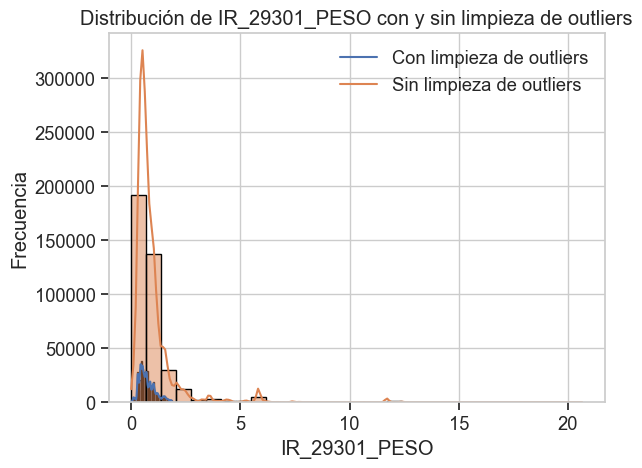

In [459]:
sns.histplot(data['IR_29301_PESO'], bins=30, kde=True)
sns.histplot(dataog['IR_29301_PESO'], bins=30, kde=True)
plt.title('Distribución de IR_29301_PESO con y sin limpieza de outliers')
plt.xlabel('IR_29301_PESO')
plt.ylabel('Frecuencia')
plt.legend(['Con limpieza de outliers', 'Sin limpieza de outliers'])
plt.show()


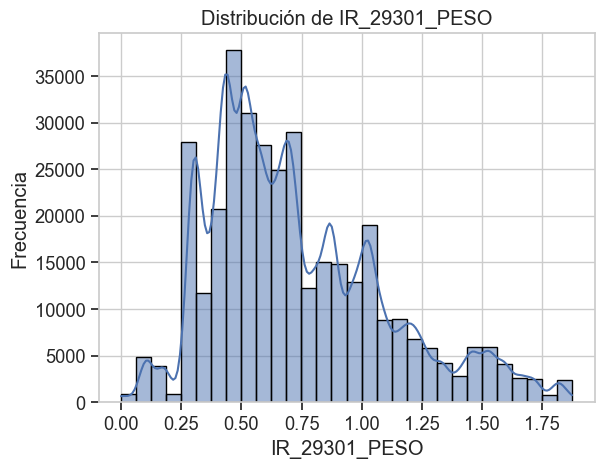

In [460]:
sns.histplot(data['IR_29301_PESO'], bins=30, kde=True)
plt.title('Distribución de IR_29301_PESO')
plt.xlabel('IR_29301_PESO')
plt.ylabel('Frecuencia')
plt.show()

- **Pregunta secundaria 1:** ¿Existe una relación significativa entre el costo y la edad de los pacientes?
- **Pregunta secundaria 2:** ¿Como distribuyen las personas con multimorbilidad en relación al costo?
- **Pregunta secundaria 3:** ¿Existen regiones cuyos costos sean diferentes en comparación al país?


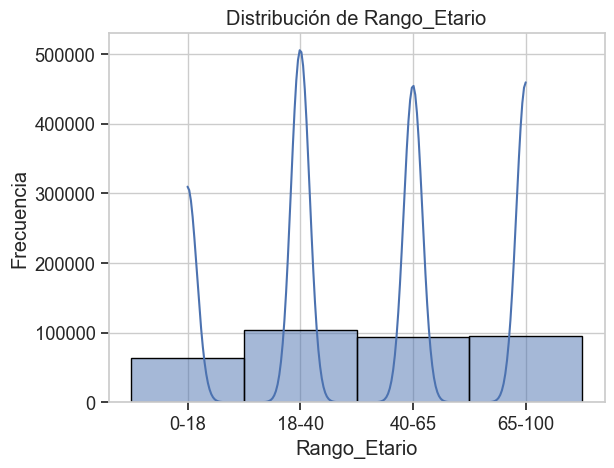

In [461]:
sns.histplot(data['Rango_Etario'], bins=30, kde=True)
plt.title('Distribución de Rango_Etario')
plt.xlabel('Rango_Etario')
plt.ylabel('Frecuencia')
plt.show()

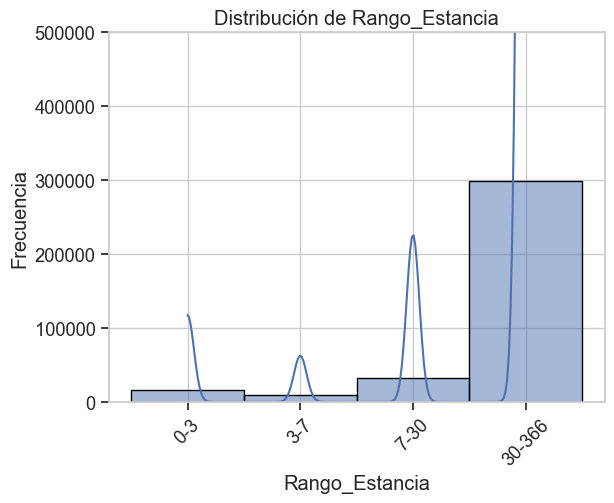

In [515]:
sns.histplot(data['Rango_Estancia'], bins=30, kde=True)
plt.title('Distribución de Rango_Estancia')
plt.xticks(rotation=45)
plt.xlabel('Rango_Estancia')
plt.ylabel('Frecuencia')
plt.ylim(0, 500000)
plt.show()

In [463]:
data['Rango_Estancia'].value_counts()

Rango_Estancia
84.85714285714286-91.71428571428571      28410
30.0-36.857142857142854                  24736
57.42857142857143-64.28571428571428      24094
112.28571428571428-119.14285714285714    22371
174.0-180.85714285714286                 19692
146.57142857142856-153.42857142857142    18888
201.42857142857142-208.28571428571428    15481
50.57142857142857-57.42857142857143      14413
139.71428571428572-146.57142857142856    11967
119.14285714285714-126.0                  9523
228.85714285714283-235.7142857142857      8938
235.7142857142857-242.57142857142856      8851
91.71428571428571-98.57142857142857       6689
263.1428571428571-270.0                   6350
78.0-84.85714285714286                    5824
208.28571428571428-215.14285714285714     5164
290.57142857142856-297.4285714285714      5037
167.14285714285714-174.0                  4920
64.28571428571428-71.14285714285714       4107
105.42857142857143-112.28571428571428     4061
36.857142857142854-43.714285714285715     401

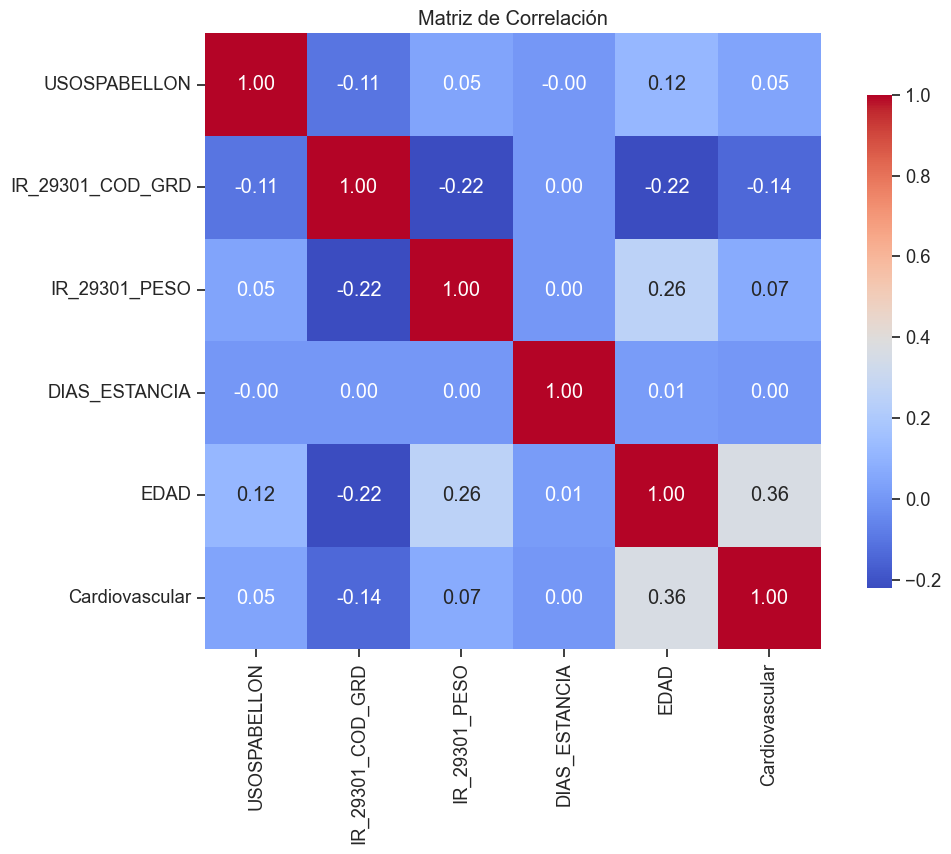

In [464]:
columns = [column for column in data.columns if (data[column].dtype in ['int64', 'int32', 'float64', 'float32']) & ~column.startswith("PROCEDIMIENTO") & ~(column in ['CIP_ENCRIPTADO','COD_HOSPITAL'])]
correlation_matrix = data[columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()


In [465]:
#¿Existe una relación significativa entre el costo y la edad de los pacientes?
#H0: No existe relación significativa entre el costo y la edad de los pacientes
#H1: Existe relación significativa entre el costo y la edad de los pacientes
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
correlation, p_value = stats.pearsonr(data_cardio['IR_29301_PESO'], data_cardio['EDAD'])
print(f"Correlation: {correlation}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una relación significativa entre el costo y la edad de los pacientes")
else:
    print("No se rechaza la hipótesis nula, no existe una relación significativa entre el costo y la edad de los pacientes")


Correlation: 0.012017224529562325, P-value: 0.007607992026357557
Rechazamos la hipótesis nula, existe una relación significativa entre el costo y la edad de los pacientes


In [466]:
#Existe una relacion entre la edad y los dias de estancia con enfermedades cardiovasculares?
#H0: No existe relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares
#H1: Existe relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
correlation, p_value = stats.pearsonr(data_cardio['DIAS_ESTANCIA'], data_cardio['EDAD'])
print(f"Correlation: {correlation}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares")
else:
    print("No se rechaza la hipótesis nula, no existe una relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares")

Correlation: 0.014124721171644396, P-value: 0.0017062738580047657
Rechazamos la hipótesis nula, existe una relación significativa entre la edad y los días de estancia con enfermedades cardiovasculares


In [467]:
#Existe una relacion entre dias de estancia y costo con enfermedades cardiovasculares?
#H0: No existe relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares
#H1: Existe relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
correlation, p_value = stats.pearsonr(data_cardio['DIAS_ESTANCIA'], data_cardio['IR_29301_PESO'])
print(f"Correlation: {correlation}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares")
else:
    print("No se rechaza la hipótesis nula, no existe una relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares")

Correlation: -0.0019657404204308426, P-value: 0.6624234843333766
No se rechaza la hipótesis nula, no existe una relación significativa entre los días de estancia y el costo con enfermedades cardiovasculares


In [ ]:
#¿Como distribuyen las personas con enfermedades Cardiovasculares en relación al costo?
#H0: No existe relación significativa entre el costo y la multimorbilidad
#H1: Existe relación significativa entre el costo y la multimorbilidad
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
df_ab_cardio = data[data['IR_29301_PESO'].notnull()].copy()
df_ab_cardio['grupo'] = df_ab_cardio['Cardiovascular'].map({0: 'Sin_Cardio', 1: 'Con_Cardio'})

grupo_sin = df_ab_cardio[df_ab_cardio['grupo'] == 'Sin_Cardio']['IR_29301_PESO']
grupo_con = df_ab_cardio[df_ab_cardio['grupo'] == 'Con_Cardio']['IR_29301_PESO']

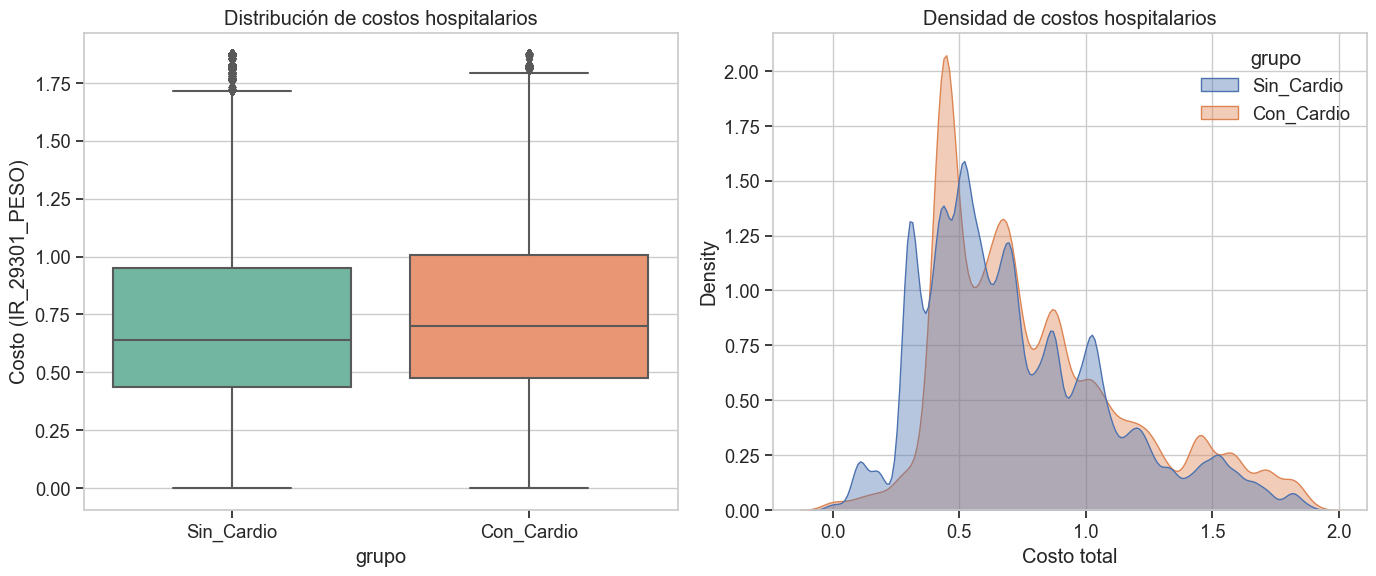

In [469]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_ab_cardio, x='grupo', y='IR_29301_PESO', palette='Set2')
plt.title('Distribución de costos hospitalarios')
plt.ylabel('Costo (IR_29301_PESO)')

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_ab_cardio, x='IR_29301_PESO', hue='grupo', fill=True, common_norm=False, alpha=0.4)
plt.title('Densidad de costos hospitalarios')
plt.xlabel('Costo total')

plt.tight_layout()
plt.show()


In [470]:
t_stat, p_valor = stats.ttest_ind(grupo_con, grupo_sin, equal_var=False)

stats_grupos = df_ab_cardio.groupby('grupo')['IR_29301_PESO'].agg(['count', 'mean', 'std', 'median'])
print("Estadísticas descriptivas por grupo:")
print(stats_grupos)

print(f"\nResultados de la prueba A/B (Costos Cardiovasculares):")
print(f"Estadístico t: {t_stat:.4f}")
print(f"Valor p: {p_valor:.4f}")

alpha = 0.05
if p_valor < alpha:
    print(f"Diferencia estadísticamente significativa (p < {alpha})")
    diff = stats_grupos.loc['Con_Cardio', 'mean'] - stats_grupos.loc['Sin_Cardio', 'mean']
    print(f"Diferencia media en el costo: ${diff:,.2f}")
else:
    print(f"No se encuentra diferencia estadísticamente significativa (p ≥ {alpha})")


Estadísticas descriptivas por grupo:
             count      mean       std  median
grupo                                         
Con_Cardio   49326  0.793372  0.378988  0.6994
Sin_Cardio  307433  0.718402  0.364688  0.6406

Resultados de la prueba A/B (Costos Cardiovasculares):
Estadístico t: 40.9944
Valor p: 0.0000
Diferencia estadísticamente significativa (p < 0.05)
Diferencia media en el costo: $0.07


In [471]:
efecto = (grupo_con.mean() - grupo_sin.mean()) / np.sqrt((grupo_con.std()**2 + grupo_sin.std()**2) / 2)
print(f"\nTamaño del efecto (d de Cohen): {efecto:.3f}")
if abs(efecto) < 0.2:
    print("Efecto pequeño")
elif abs(efecto) < 0.5:
    print("Efecto mediano")
else:
    print("Efecto grande")



Tamaño del efecto (d de Cohen): 0.202
Efecto mediano


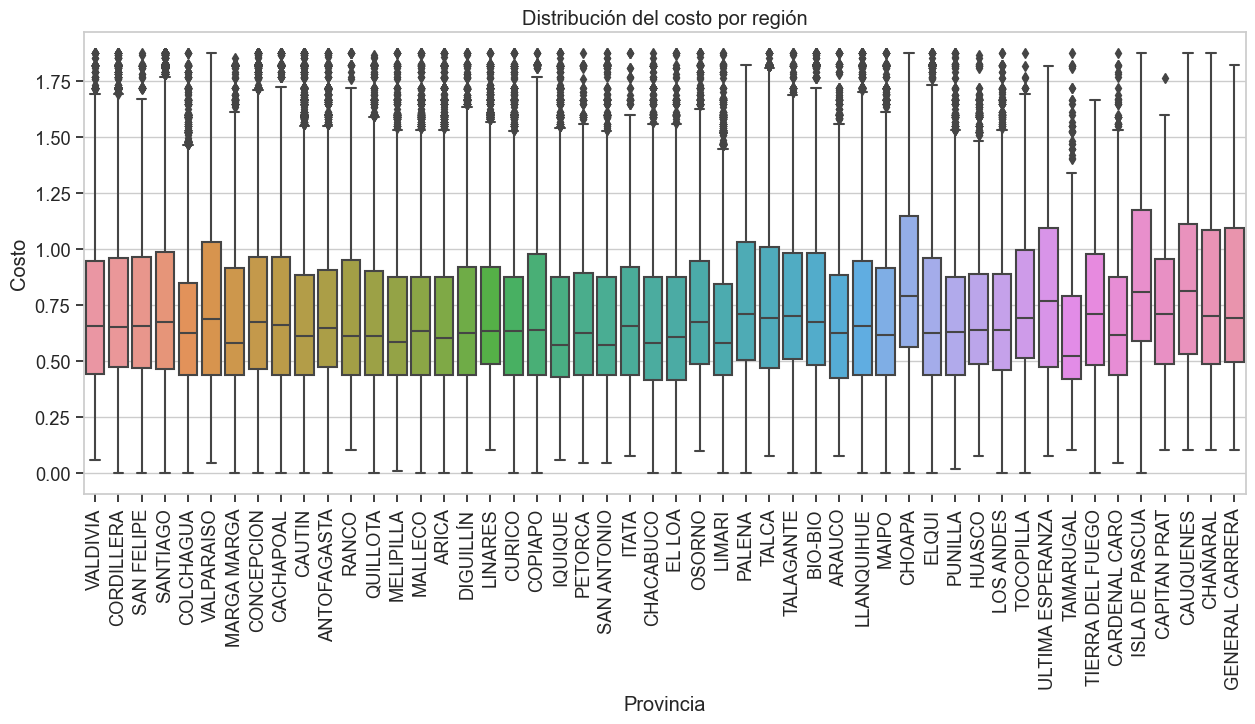

In [472]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=data, x='PROVINCIA', y='IR_29301_PESO')
plt.title('Distribución del costo por región')
plt.xticks(rotation=90)
plt.xlabel('Provincia')
plt.ylabel('Costo')
plt.show()

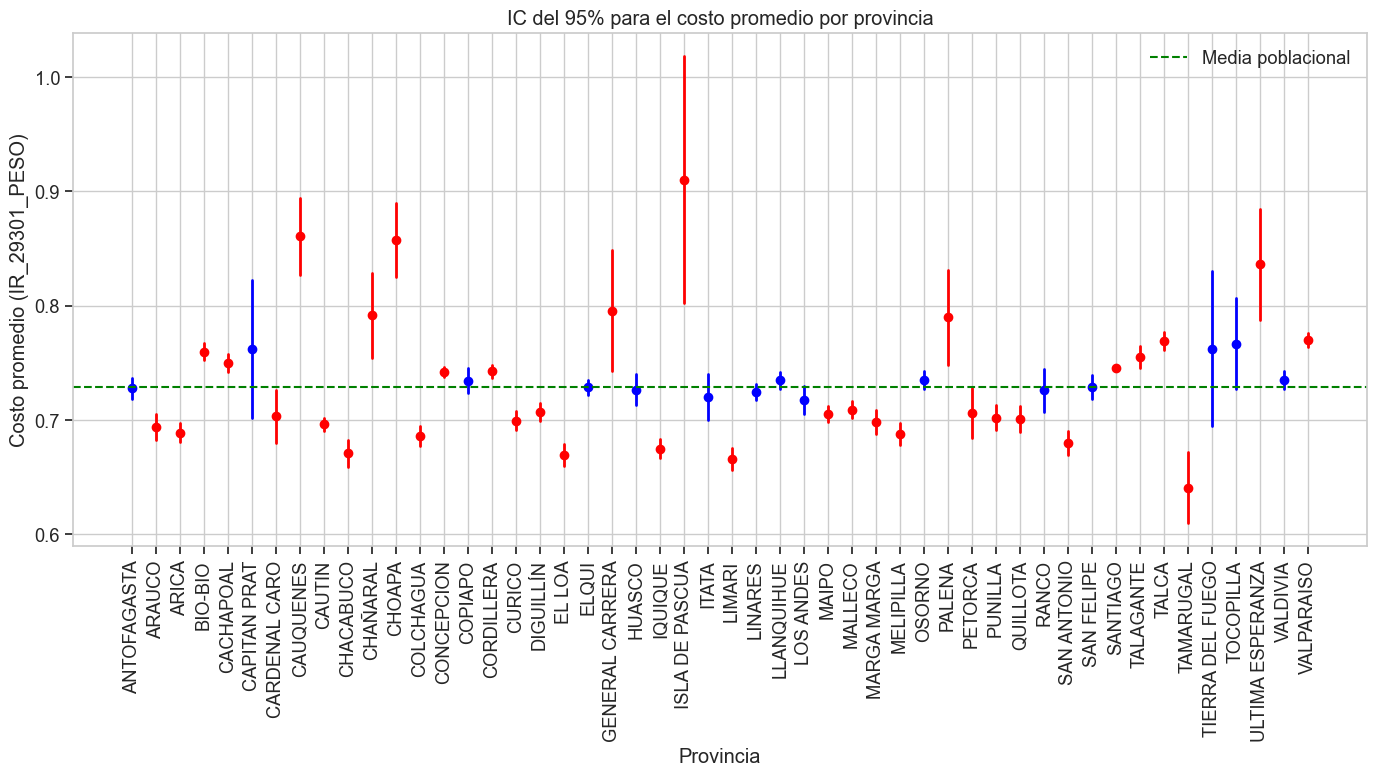

In [473]:

media_poblacional = data['IR_29301_PESO'].mean()
provincias = data['PROVINCIA'].unique()
provincias.sort()

intervalos = []
medias = []
labels = []
colores = []

n_min = data['PROVINCIA'].value_counts().min()

for prov in provincias:
    subset = data[data['PROVINCIA'] == prov]['IR_29301_PESO'].dropna()
    n = len(subset)

    if n >= n_min:
        media = np.mean(subset)
        std = np.std(subset, ddof=1)
        error_estandar = std / np.sqrt(n)
        valor_t = stats.t.ppf(0.975, n - 1)
        margen_error = valor_t * error_estandar

        intervalo_inf = media - margen_error
        intervalo_sup = media + margen_error

        contiene = intervalo_inf <= media_poblacional <= intervalo_sup
        color = 'blue' if contiene else 'red'

        intervalos.append((intervalo_inf, intervalo_sup))
        medias.append(media)
        labels.append(prov)
        colores.append(color)

plt.figure(figsize=(14, 8))

for i, (media, (inf, sup), color) in enumerate(zip(medias, intervalos, colores)):
    plt.plot([i, i], [inf, sup], color=color, linewidth=2)
    plt.plot(i, media, 'o', color=color)

plt.axhline(y=media_poblacional, color='green', linestyle='--', label='Media poblacional')

plt.xticks(range(len(labels)), labels, rotation=90)
plt.xlabel('Provincia')
plt.ylabel('Costo promedio (IR_29301_PESO)')
plt.title('IC del 95% para el costo promedio por provincia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [474]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

modelo = ols('IR_29301_PESO ~ C(PROVINCIA)', data=data).fit()
anova = sm.stats.anova_lm(modelo, typ=2)
print(anova)


                    sum_sq        df          F  PR(>F)
C(PROVINCIA)    286.726511      49.0  43.554129     0.0
Residual      47924.380423  356709.0        NaN     NaN


In [475]:
grupos = [grupo['IR_29301_PESO'].dropna() for _, grupo in data.groupby('PROVINCIA')]

#ANOVA
f_stat, p_value = stats.f_oneway(*grupos)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Rechazamos H0: Al menos una región tiene un costo significativamente diferente al promedio nacional.")
else:
    print("No se rechaza H0: No hay evidencia suficiente para afirmar diferencias entre regiones.")


F-statistic: 43.554128679384924, P-value: 0.0
Rechazamos H0: Al menos una región tiene un costo significativamente diferente al promedio nacional.


In [476]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=data['IR_29301_PESO'],
                          groups=data['PROVINCIA'],
                          alpha=0.05)
print(tukey)


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
     ANTOFAGASTA           ARAUCO  -0.0339 0.0075 -0.0641 -0.0036   True
     ANTOFAGASTA            ARICA  -0.0387    0.0 -0.0637 -0.0138   True
     ANTOFAGASTA          BIO-BIO   0.0323    0.0  0.0096  0.0551   True
     ANTOFAGASTA        CACHAPOAL   0.0221 0.1321 -0.0018   0.046  False
     ANTOFAGASTA     CAPITAN PRAT   0.0349    1.0 -0.0972   0.167  False
     ANTOFAGASTA    CARDENAL CARO  -0.0246 0.9996 -0.0752   0.026  False
     ANTOFAGASTA        CAUQUENES   0.1332    0.0  0.0695  0.1969   True
     ANTOFAGASTA           CAUTIN  -0.0315    0.0 -0.0528 -0.0102   True
     ANTOFAGASTA        CHACABUCO  -0.0569    0.0 -0.0873 -0.0266   True
     ANTOFAGASTA         CHAÑARAL    0.064 0.1727 -0.0068  0.1349  False
     ANTOFAGASTA           CHOAPA   0.1301    0.0  

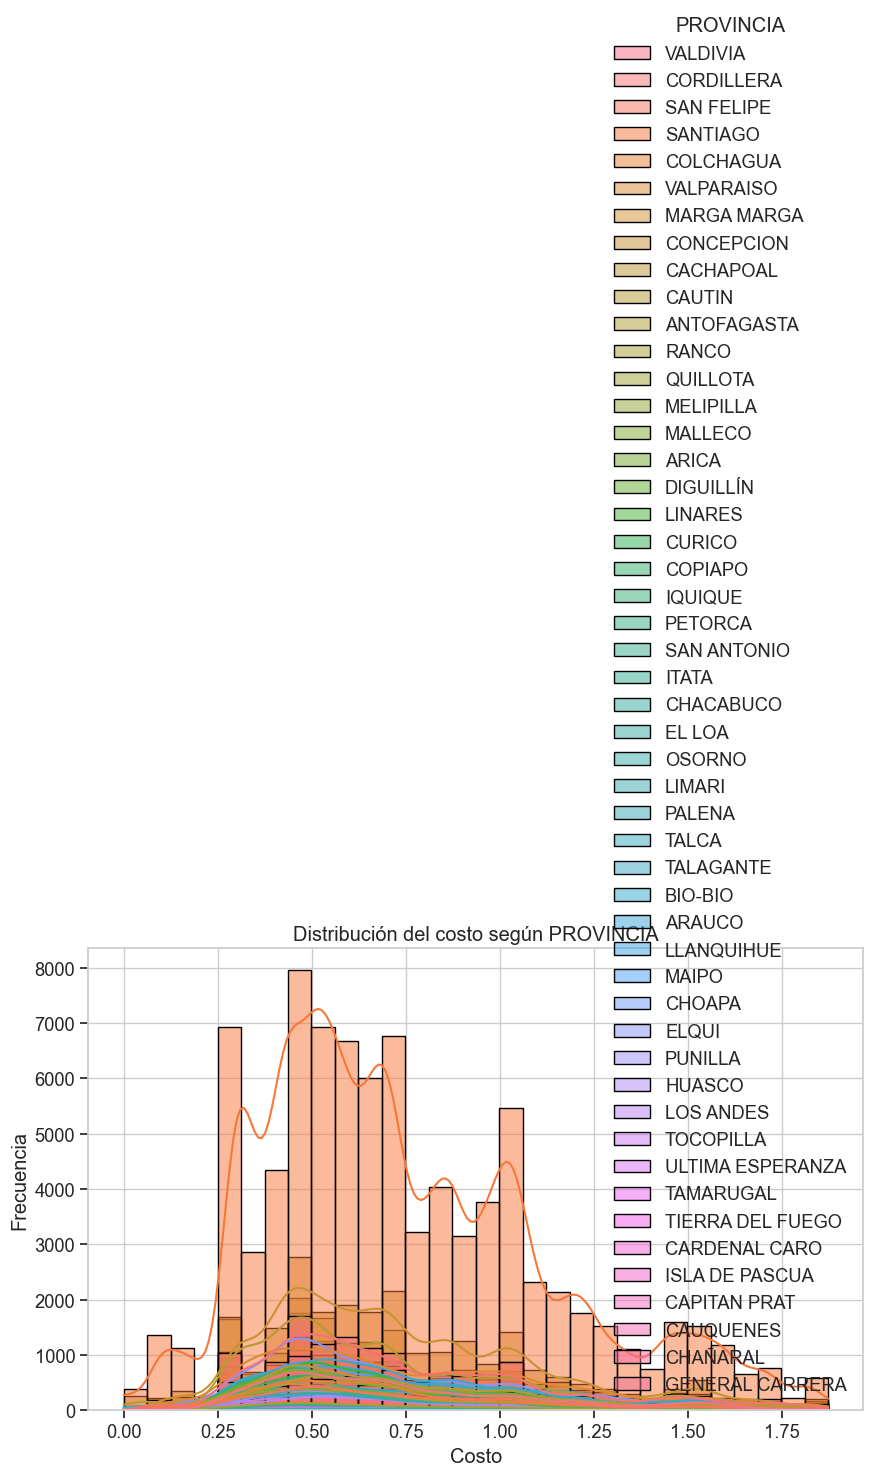

In [477]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='IR_29301_PESO', hue='PROVINCIA', kde=True, bins=30)
plt.title('Distribución del costo según PROVINCIA')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')
plt.show()

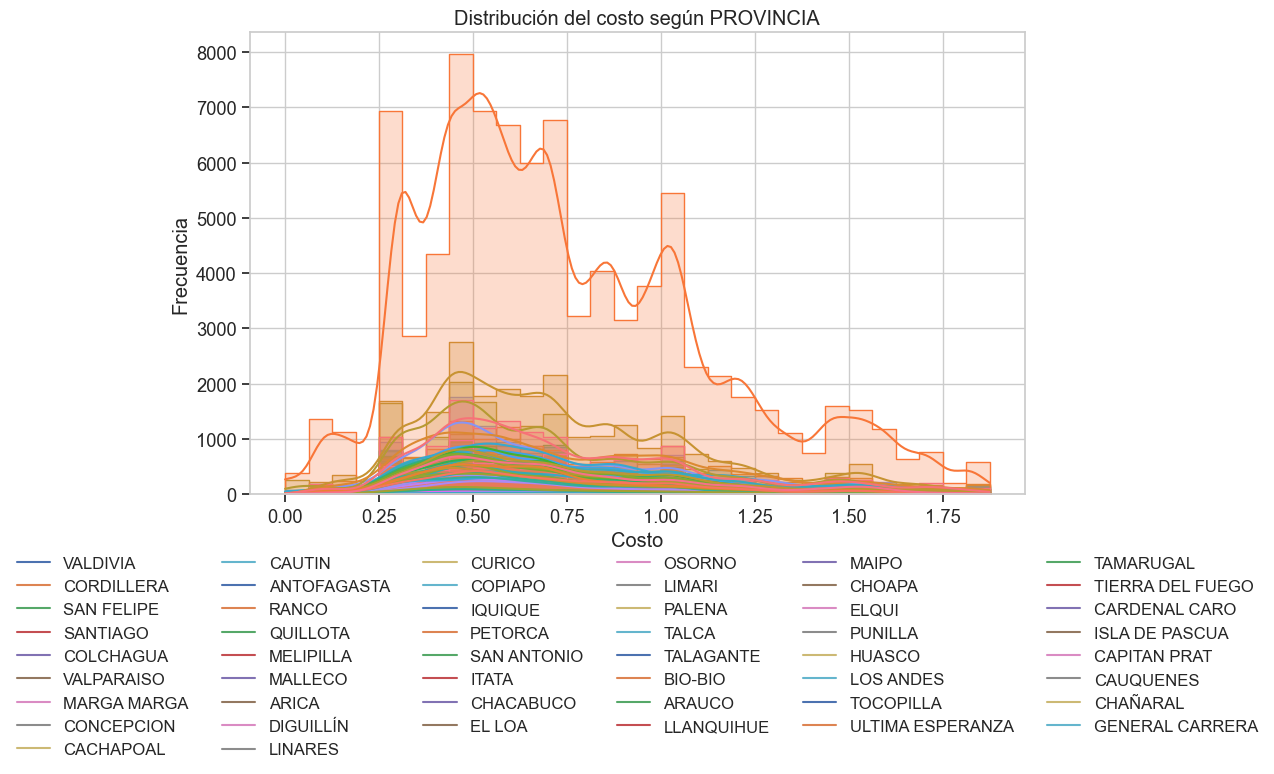

In [478]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='IR_29301_PESO', hue='PROVINCIA', kde=True, bins=30, element='step', legend=True)
plt.title('Distribución del costo según PROVINCIA')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')

unique_labels = list(data['PROVINCIA'].unique())
palette = sns.color_palette(n_colors=len(unique_labels))

handles = [Line2D([0], [0], color=palette[i]) for i in range(len(unique_labels))]

ax.legend(handles=handles, labels=unique_labels, ncol=6, fontsize='small', loc='upper center', bbox_to_anchor=(0.5, -0.1))

plt.show()

T-statistic: -40.994350130565785, P-value: 0.0
Rechazamos la hipótesis nula, existe una diferencia significativa en el costo entre personas con y sin enfermedades cardiovasculares.


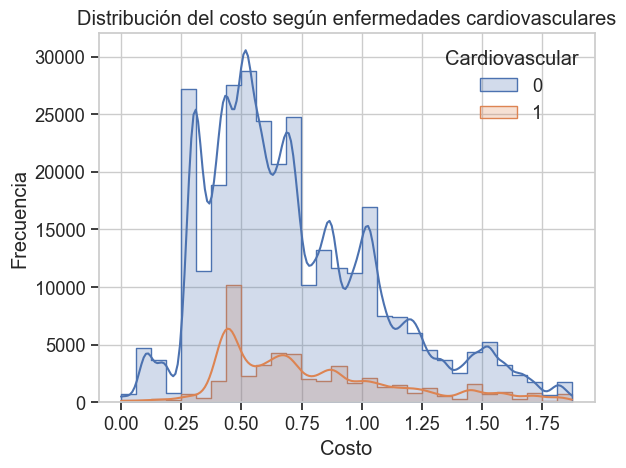

In [479]:
#¿Como distribuyen las personas con enfermedades cardiacas en relación al costo?
#H0: No existe relación significativa entre el costo y la enfermedad cardiaca
#H1: Existe relación significativa entre el costo y la enfermedad cardiaca
#Se utiliza la prueba de correlación de Pearson para determinar la relación entre las dos variables
grupo_sin = data[data['Cardiovascular'] == 0]['IR_29301_PESO']
grupo_con = data[data['Cardiovascular'] == 1]['IR_29301_PESO']
t_stat, p_value = stats.ttest_ind(grupo_sin, grupo_con, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < 0.05:
    print("Rechazamos la hipótesis nula, existe una diferencia significativa en el costo entre personas con y sin enfermedades cardiovasculares.")
else:
    print("No se rechaza la hipótesis nula, no existe una diferencia significativa en el costo entre personas con y sin enfermedades cardiovasculares.")
sns.histplot(data=data, x='IR_29301_PESO', hue='Cardiovascular', kde=True, bins=30, element='step')
plt.title('Distribución del costo según enfermedades cardiovasculares')
plt.xlabel('Costo')
plt.ylabel('Frecuencia')
plt.show()



In [480]:
def Lowess_plot_cardiovascular(df, column1, column2, frac=0.2):
    for cardiopatia, color, label in zip([0, 1], ['blue', 'orange'], ['No', 'Sí']):
        subset = df[df['Cardiovascular'] == cardiopatia]
        x = subset[column1]
        y = subset[column2]

        lowess_result = sm.nonparametric.lowess(y, x, frac)
        x_lowess, y_lowess = lowess_result[:, 0], lowess_result[:, 1]

        plt.plot(x_lowess, y_lowess, label=f'Cardiopatía: {label}', color=color)

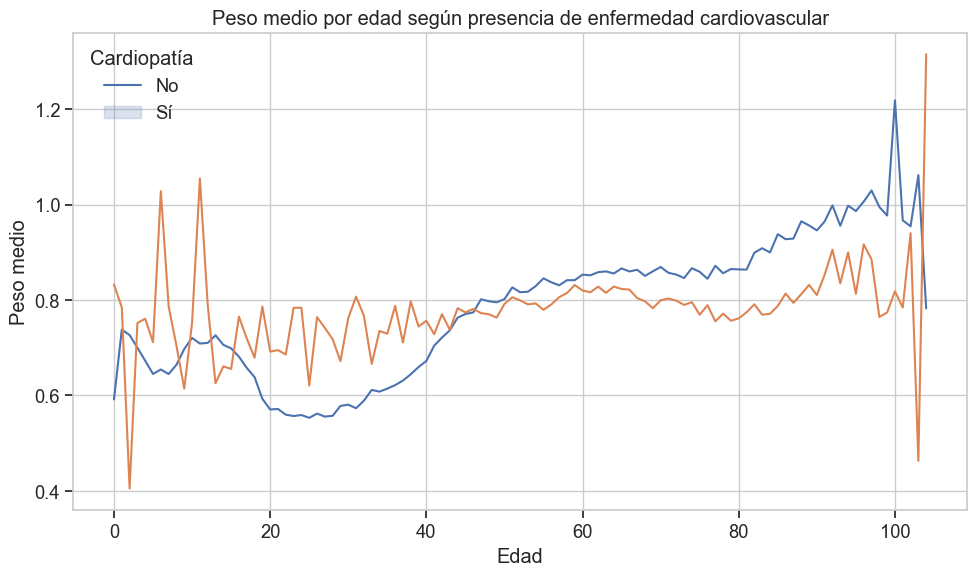

In [481]:
df = data.dropna(subset=['EDAD', 'IR_29301_PESO', 'Cardiovascular'])

media_por_edad = df.groupby(['EDAD', 'Cardiovascular'])['IR_29301_PESO'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_por_edad, x='EDAD', y='IR_29301_PESO', hue='Cardiovascular')

plt.title('Peso medio por edad según presencia de enfermedad cardiovascular')
plt.xlabel('Edad')
plt.ylabel('Peso medio')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

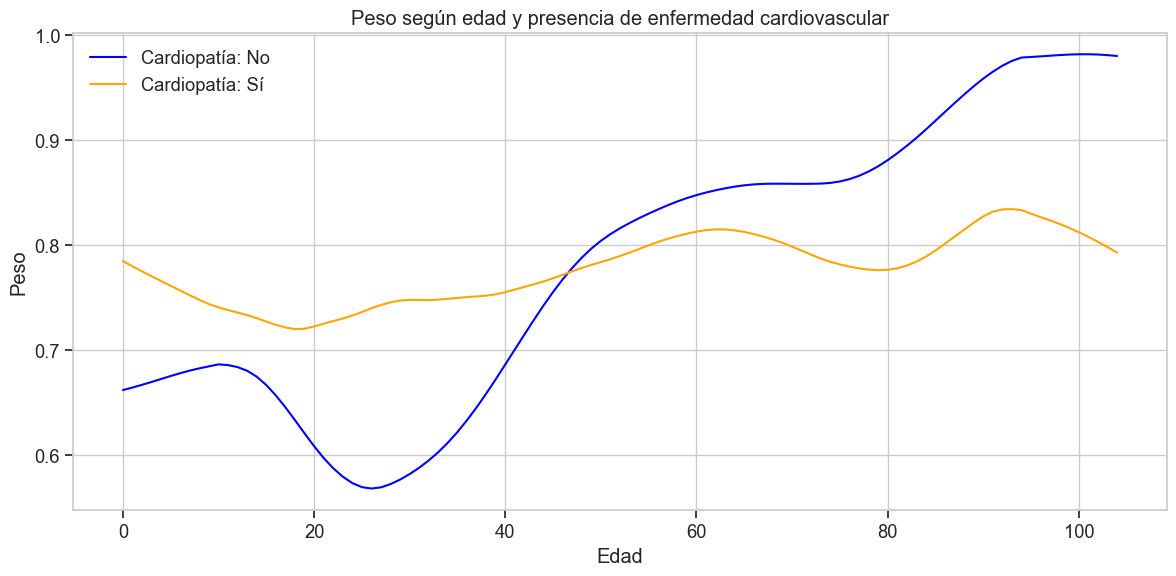

In [482]:

plt.figure(figsize=(12, 6))

Lowess_plot_cardiovascular(media_por_edad, 'EDAD', 'IR_29301_PESO', frac=0.2)

plt.title('Peso según edad y presencia de enfermedad cardiovascular')
plt.xlabel('Edad')
plt.ylabel('Peso')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


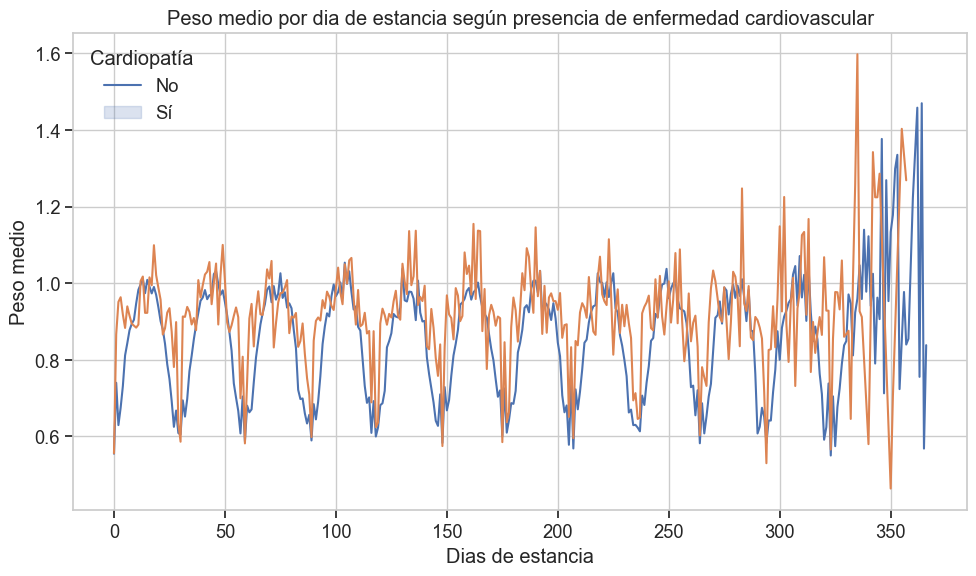

In [483]:
df = data.dropna(subset=['DIAS_ESTANCIA', 'IR_29301_PESO', 'Cardiovascular'])

media_dias_estancia = df.groupby(['DIAS_ESTANCIA', 'Cardiovascular'])['IR_29301_PESO'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_dias_estancia, x='DIAS_ESTANCIA', y='IR_29301_PESO', hue='Cardiovascular')

plt.title('Peso medio por dia de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('Dias de estancia')
plt.ylabel('Peso medio')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

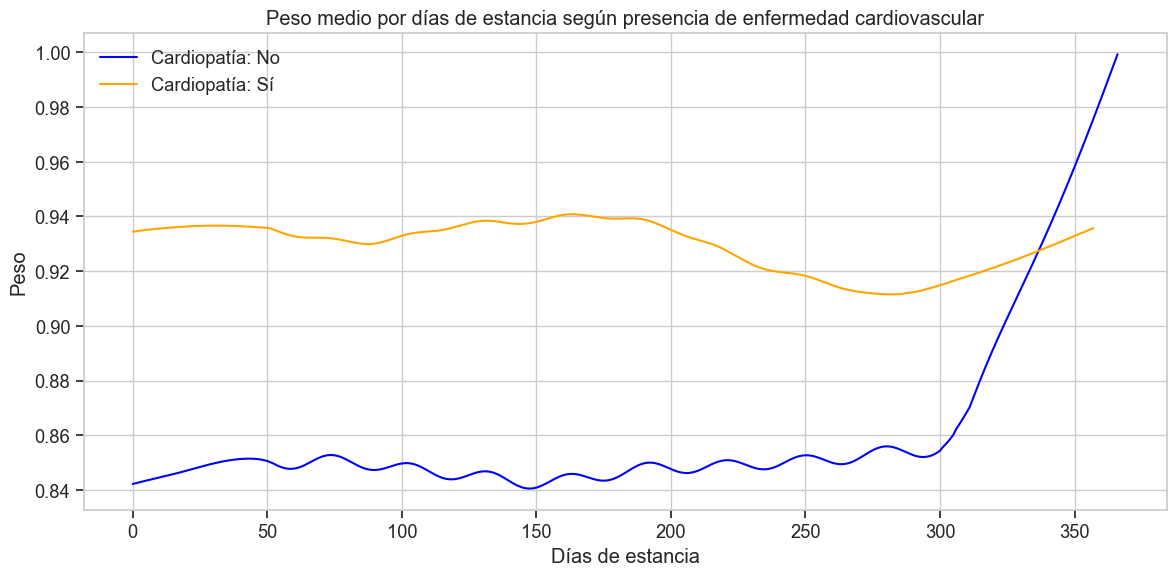

In [484]:
plt.figure(figsize=(12, 6))


Lowess_plot_cardiovascular(media_dias_estancia, 'DIAS_ESTANCIA', 'IR_29301_PESO', frac=0.3)

plt.title('Peso medio por días de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('Días de estancia')
plt.ylabel('Peso')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [485]:
data.groupby('DIAS_ESTANCIA')['IR_29301_PESO'].agg(['mean', 'std', 'count'])


,mean,std,count
DIAS_ESTANCIA,,,
0,0.555190,0.277842,7532
1,0.758890,0.342142,4506
2,0.662007,0.354895,4698
3,0.706311,0.365406,3739
4,0.752406,0.373472,2051
...,...,...,...
362,1.458400,0.106626,3
363,0.755600,0.175732,3
364,1.470000,NaN,1


<Axes: xlabel='IR_29301_PESO', ylabel='Count'>

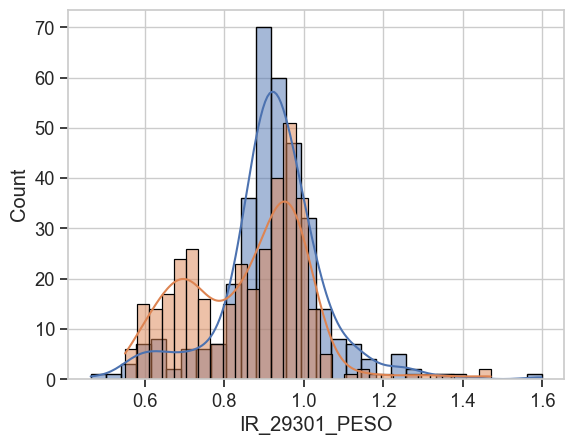

In [486]:
sns.histplot(data_cardio.groupby('DIAS_ESTANCIA')['IR_29301_PESO'].mean(), bins=30, kde=True)
sns.histplot(data_no_cardio.groupby('DIAS_ESTANCIA')['IR_29301_PESO'].mean(), bins=30, kde=True)

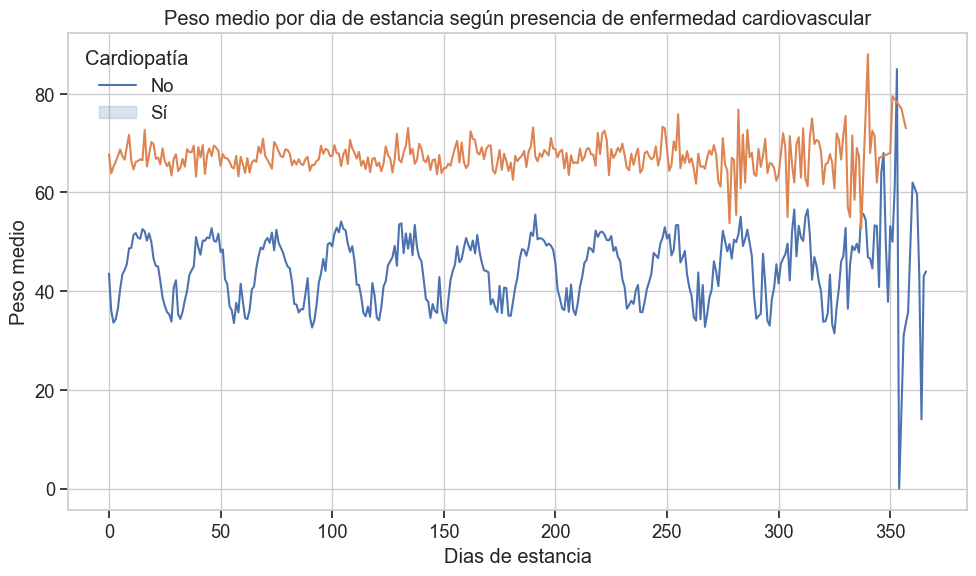

In [487]:
df = data.dropna(subset=['DIAS_ESTANCIA', 'EDAD', 'Cardiovascular'])

media_dias_estancia = df.groupby(['DIAS_ESTANCIA', 'Cardiovascular'])['EDAD'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_dias_estancia, x='DIAS_ESTANCIA', y='EDAD', hue='Cardiovascular')

plt.title('Peso medio por dia de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('Dias de estancia')
plt.ylabel('Peso medio')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

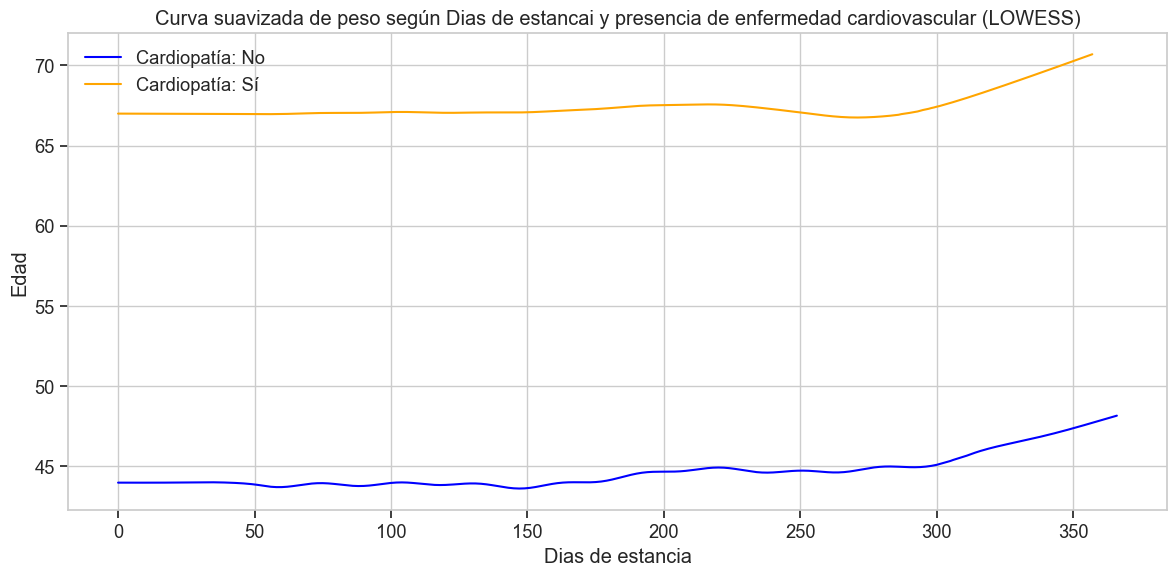

In [488]:
plt.figure(figsize=(12, 6))

Lowess_plot_cardiovascular(media_dias_estancia, 'DIAS_ESTANCIA', 'EDAD', frac=0.3)
plt.title('Curva suavizada de peso según Dias de estancai y presencia de enfermedad cardiovascular (LOWESS)')
plt.xlabel('Dias de estancia')
plt.ylabel('Edad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

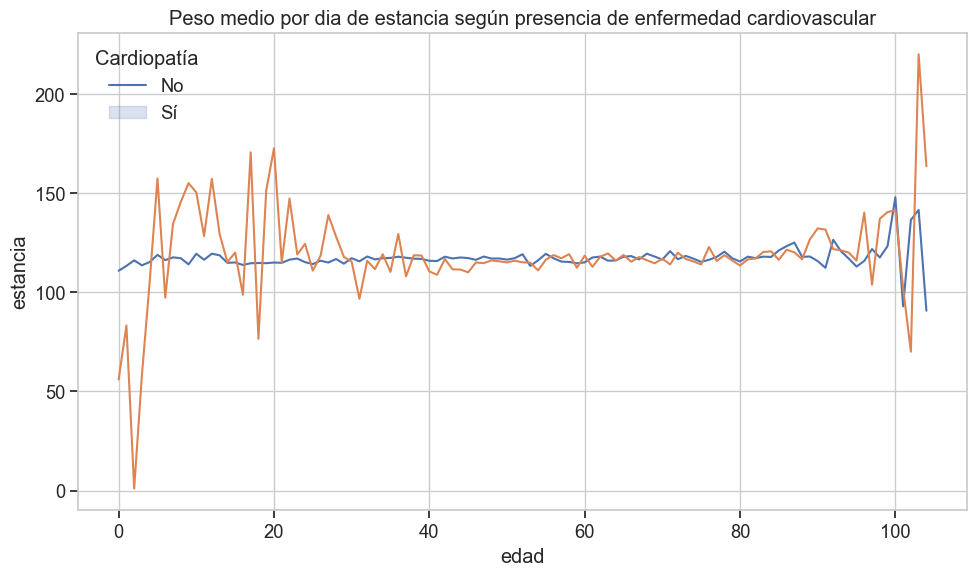

In [489]:
df = data.dropna(subset=['DIAS_ESTANCIA', 'EDAD', 'Cardiovascular'])

media_dias_estancia = df.groupby(['EDAD', 'Cardiovascular'])['DIAS_ESTANCIA'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_dias_estancia, x='EDAD', y='DIAS_ESTANCIA', hue='Cardiovascular')

plt.title('Peso medio por dia de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('edad')
plt.ylabel('estancia')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

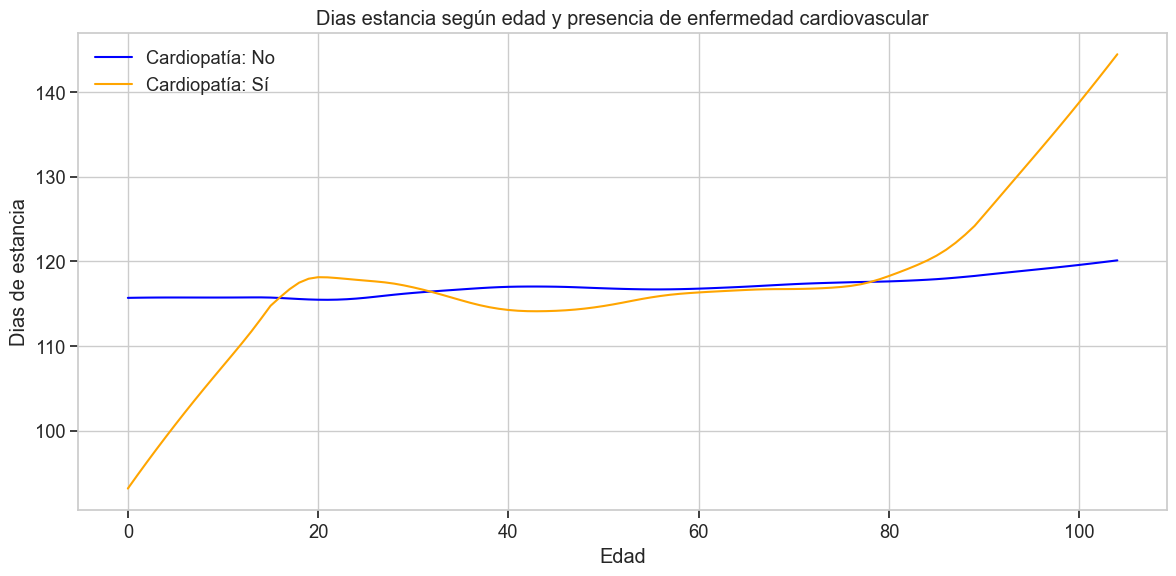

In [490]:
plt.figure(figsize=(12, 6))

Lowess_plot_cardiovascular(media_dias_estancia, 'EDAD', 'DIAS_ESTANCIA', frac=0.3)
plt.title('Dias estancia según edad y presencia de enfermedad cardiovascular')
plt.ylabel('Dias de estancia')
plt.xlabel('Edad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

La edad donde comienza el crecimiento pronunciado es aproximadamente: 78.0 años (valor: 112.52692341428057)


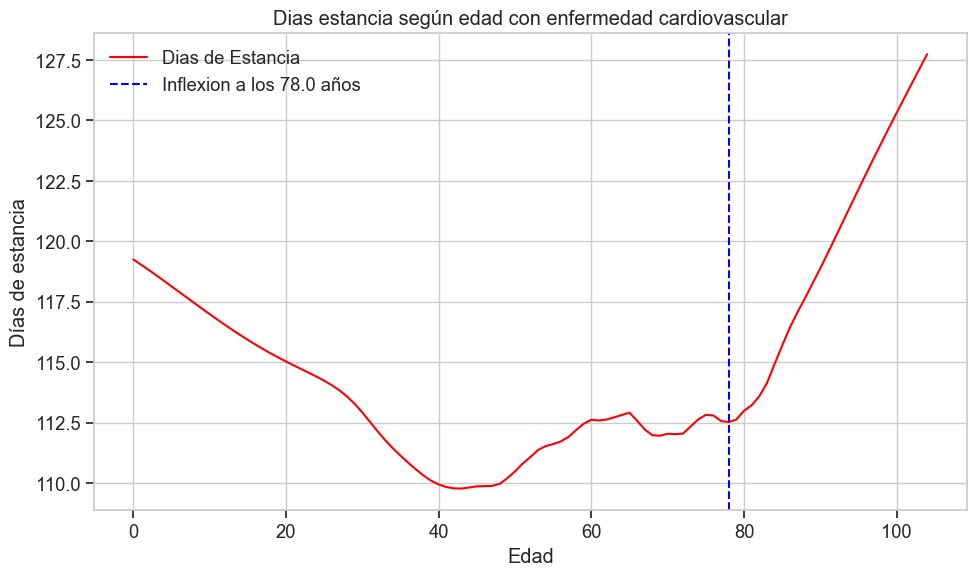

In [491]:
subset = df[df['Cardiovascular'] == 1]
x = subset['EDAD']
y = subset['DIAS_ESTANCIA']

lowess_result = sm.nonparametric.lowess(y, x, frac=0.3, return_sorted=True)
x_smooth = lowess_result[:, 0]
y_smooth = lowess_result[:, 1]

x_unique, idx_unique = np.unique(x_smooth, return_index=True)
y_unique = y_smooth[idx_unique]

mask = (x_unique >= 60) & (x_unique <= 80)
x_range = x_unique[mask]
y_range = y_unique[mask]

dy_dx = np.gradient(y_range, x_range)

d2y_dx2 = np.gradient(dy_dx, x_range)

inflexion_idx = np.argmax(d2y_dx2)
inflexion_x = x_range[inflexion_idx]
inflexion_y = y_range[inflexion_idx]

print(f"La edad donde comienza el crecimiento pronunciado es aproximadamente: {inflexion_x} años (valor: {inflexion_y})")

plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label='Dias de Estancia', color='red')
plt.axvline(inflexion_x, color='blue', linestyle='--', label=f'Inflexion a los {inflexion_x} años')
plt.xlabel('Edad')
plt.ylabel('Días de estancia')
plt.title('Dias estancia según edad con enfermedad cardiovascular')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [492]:
df = data.dropna(subset=['EDAD', 'IR_29301_PESO', 'Cardiovascular'])

media_por_edad = df.groupby(['EDAD', 'Cardiovascular'])['IR_29301_PESO'].mean().reset_index()

In [493]:
def Lowess_plot_cardiovascular(df, column1, column2, frac=0.2):
    curves = {}

    for cardiopatia, color, label in zip([0, 1], ['blue', 'orange'], ['No', 'Sí']):
        subset = df[df['Cardiovascular'] == cardiopatia]
        x = subset[column1]
        y = subset[column2]

        lowess_result = sm.nonparametric.lowess(y, x, frac)
        x_lowess, y_lowess = lowess_result[:, 0], lowess_result[:, 1]

        curves[cardiopatia] = (x_lowess, y_lowess)

        plt.plot(x_lowess, y_lowess, label=f'Cardiopatía: {label}', color=color)

    return curves


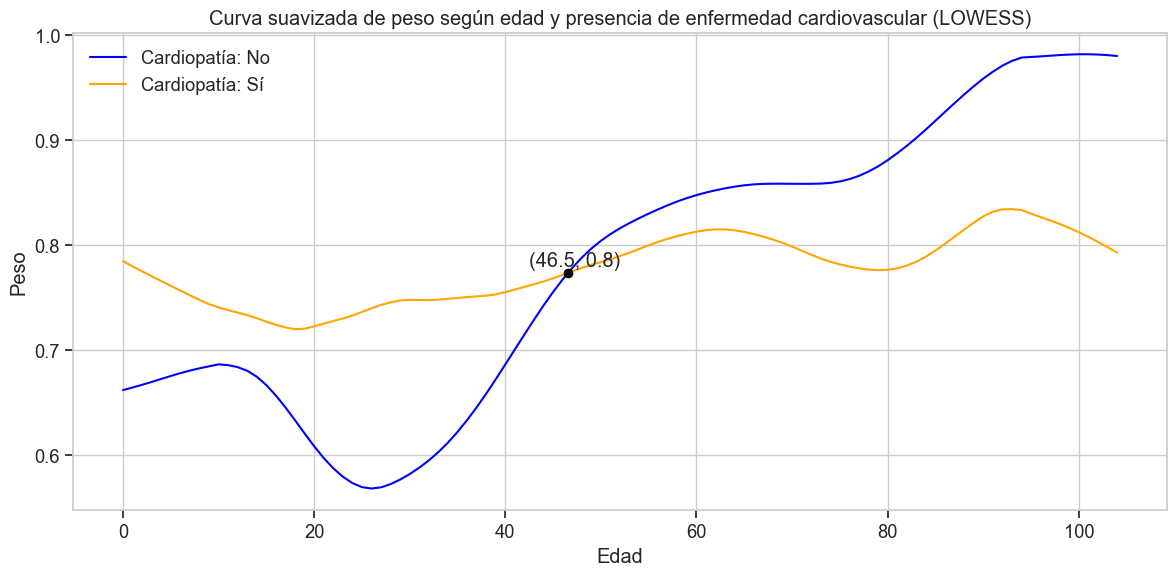

In [494]:
plt.figure(figsize=(12, 6))

curves = Lowess_plot_cardiovascular(media_por_edad, 'EDAD', 'IR_29301_PESO', frac=0.2)

x_common = np.linspace(
    max(min(curves[0][0]), min(curves[1][0])),
    min(max(curves[0][0]), max(curves[1][0])),
    1000
)
y0_interp = np.interp(x_common, curves[0][0], curves[0][1])
y1_interp = np.interp(x_common, curves[1][0], curves[1][1])

diff = y0_interp - y1_interp
sign_change = np.where(np.diff(np.sign(diff)))[0]

for idx in sign_change:
    xi = x_common[idx]
    yi = y0_interp[idx]
    plt.plot(xi, yi, 'ko')
    plt.annotate(f'({xi:.1f}, {yi:.1f})', (xi, yi), textcoords="offset points", xytext=(5,5), ha='center')

plt.title('Curva suavizada de peso según edad y presencia de enfermedad cardiovascular (LOWESS)')
plt.xlabel('Edad')
plt.ylabel('Peso')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [495]:
data.groupby(['Cardiovascular', 'EDAD'])['IR_29301_PESO'].agg(['mean', 'count', 'median'])


mean  count   median
Cardiovascular EDAD                          
0              0     0.591440  17320  0.53460
               1     0.737875   5223  0.61720
               2     0.726405   3153  0.61720
               3     0.699986   2977  0.58210
               4     0.672554   3099  0.58210
...                       ...    ...      ...
1              100   0.818211      9  0.65720
               101   0.784160      5  0.73980
               102   0.940050      6  1.03260
               103   0.462800      2  0.46280
               104   1.315350      2  1.31535

[210 rows x 3 columns]

In [496]:

data.groupby(['Rango_Etario', 'Cardiovascular'])['IR_29301_PESO'].mean().unstack()


Cardiovascular,0,1
Rango_Etario,,
0-18,0.665373,0.746387
18-40,0.588285,0.746268
40-65,0.803015,0.801109
65-100,0.876755,0.791482


<Axes: xlabel='Rango_Etario', ylabel='IR_29301_PESO'>

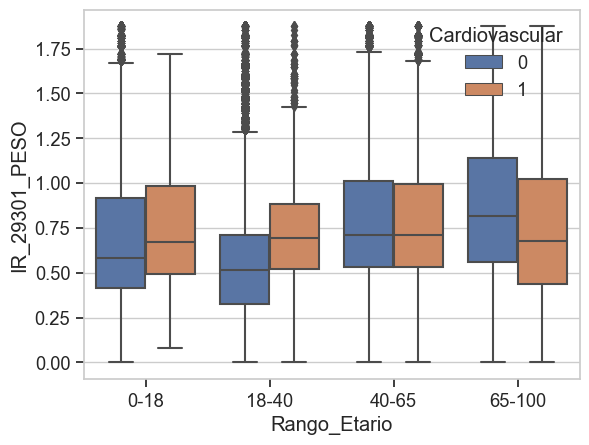

In [497]:
sns.boxplot(data=data, x='Rango_Etario', y='IR_29301_PESO', hue='Cardiovascular')

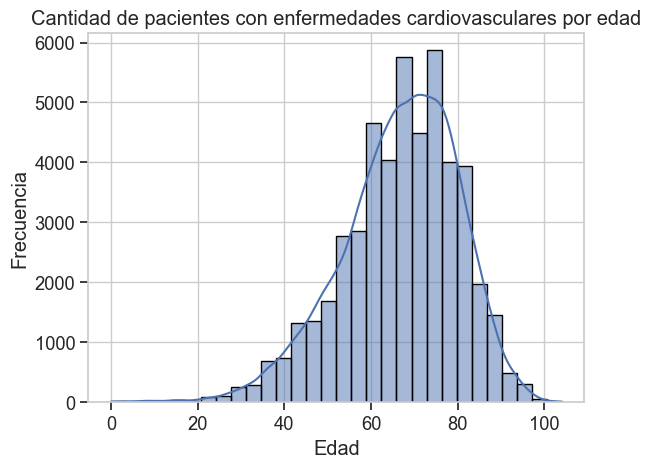

In [498]:
sns.histplot(data[data["Cardiovascular"] == 1]['EDAD'], bins=30, kde=True)
plt.title('Cantidad de pacientes con enfermedades cardiovasculares por edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()


In [499]:
data_cardio

,COD_HOSPITAL,CIP_ENCRIPTADO,SEXO,FECHA_NACIMIENTO,PROVINCIA,COMUNA,NACIONALIDAD,PREVISION,SERVICIO_SALUD,TIPO_PROCEDENCIA,...,DIAGNOSTICO33,DIAGNOSTICO34,DIAGNOSTICO35,USOSPABELLON,IR_29301_COD_GRD,IR_29301_PESO,DIAS_ESTANCIA,EDAD,Rango_Etario,Cardiovascular
106,117101,79585003.0,MUJER,1956-03-01,DIGUILLÍN,PINTO,CHILE,FONASA INSTITUCIONAL - (MAI) C,ÑUBLE,APS CONSULTORIO (CESFAM),...,NaN,NaN,NaN,1.0,71141.0,0.8759,238,67,65-100,1
333,115107,83229559.0,MUJER,1963-02-03,COLCHAGUA,SAN FERNANDO,CHILE,FONASA INSTITUCIONAL - (MAI) D,LIBERTADOR B. O HIGGINS,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,1.0,131301.0,0.6406,61,60,40-65,1
340,104100,74445532.0,MUJER,1946-12-14,COPIAPO,DIEGO DE ALMAGRO,CHILE,FONASA INSTITUCIONAL - (MAI) B,ATACAMA,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,1.0,52170.0,0.5791,118,76,65-100,1
433,118100,70827873.0,MUJER,1948-09-14,CONCEPCION,CHIGUAYANTE,CHILE,FONASA INSTITUCIONAL - (MAI) B,CONCEPCIÓN,APS CONSULTORIO (CESFAM),...,NaN,NaN,NaN,NaN,94121.0,0.4193,112,74,65-100,1
438,113100,78809502.0,MUJER,1946-07-29,MAIPO,SAN BERNARDO,CHILE,FONASA INSTITUCIONAL - (MAI) A,METROPOLITANO SUR,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,1.0,81041.0,1.4477,179,77,65-100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039302,116108,71215885.0,HOMBRE,1974-02-01,LINARES,LONGAVÍ,CHILE,FONASA INSTITUCIONAL - (MAI) B,DEL MAULE,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,1.0,22360.0,0.4384,177,49,40-65,1
1039354,104100,77763104.0,HOMBRE,1965-05-05,COPIAPO,COPIAPO,CHILE,FONASA INSTITUCIONAL - (MAI) D,ATACAMA,SERVICIO EMERGENCIA (DOMICILIO),...,NaN,NaN,NaN,NaN,64182.0,0.6736,276,58,40-65,1
1039385,124105,78101500.0,MUJER,1968-10-16,LLANQUIHUE,PUERTO MONTT,CHILE,FONASA INSTITUCIONAL - (MAI) B,DEL RELONCAVÍ,SERVICIO EMERGENCIA (DOMICILIO),...,NaN,NaN,NaN,4.0,51402.0,1.8183,62,54,40-65,1
1039392,129106,73993843.0,HOMBRE,1962-11-26,MALLECO,TRAIGUÉN,CHILE,FONASA INSTITUCIONAL - (MAI) B,ARAUCANÍA NORTE,"CENTRO ESPECIALIDADES (CDT, CRS, CONSULTORIO A...",...,NaN,NaN,NaN,1.0,121101.0,1.0902,167,61,40-65,1


In [500]:
data_edad_peso = data_cardio[data_cardio['Rango_Etario'] == '65-100'].groupby(['Rango_Etario','DIAGNOSTICO1'])["IR_29301_PESO"].mean().sort_values(ascending=False).reset_index()
data_edad_peso

,Rango_Etario,DIAGNOSTICO1,IR_29301_PESO
0,65-100,C71.8,1.8731
1,65-100,C41.8,1.8731
2,65-100,C71.6,1.8731
3,65-100,M95.2,1.8731
4,65-100,Q07.0,1.8731
...,...,...,...
7483,40-65,Z75.1,NaN
7484,40-65,Z75.4,NaN
7485,40-65,Z76.8,NaN
7486,40-65,Z85.4,NaN


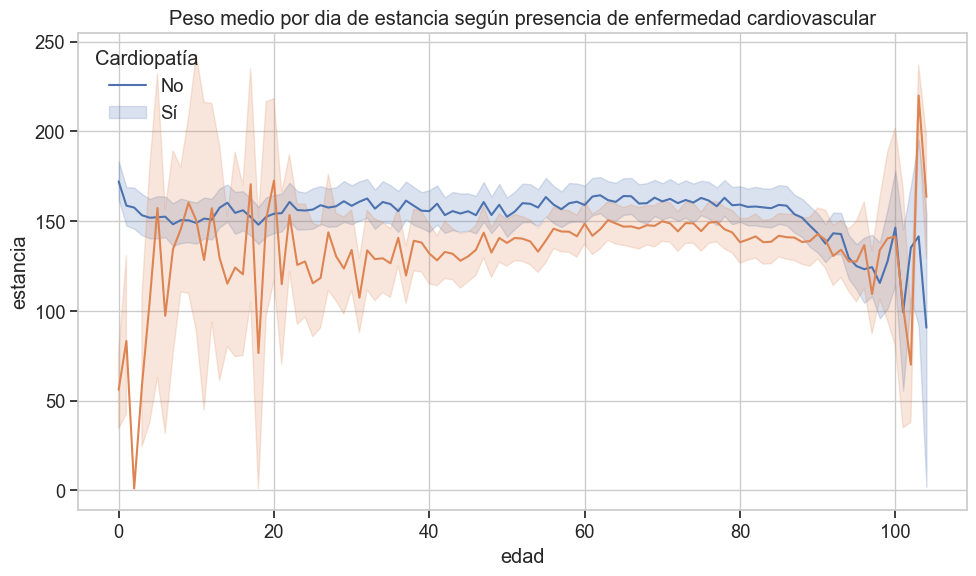

In [501]:
df = data.dropna(subset=['DIAS_ESTANCIA', 'EDAD', 'Cardiovascular', 'IR_29301_PESO'])

media_dias_estancia = df.groupby(['EDAD', 'Cardiovascular', 'DIAS_ESTANCIA'])['IR_29301_PESO'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=media_dias_estancia, x='EDAD', y='DIAS_ESTANCIA', hue='Cardiovascular')

plt.title('Peso medio por dia de estancia según presencia de enfermedad cardiovascular')
plt.xlabel('edad')
plt.ylabel('estancia')
plt.legend(title='Cardiopatía', labels=['No', 'Sí'])
plt.grid(True)
plt.tight_layout()
plt.show()

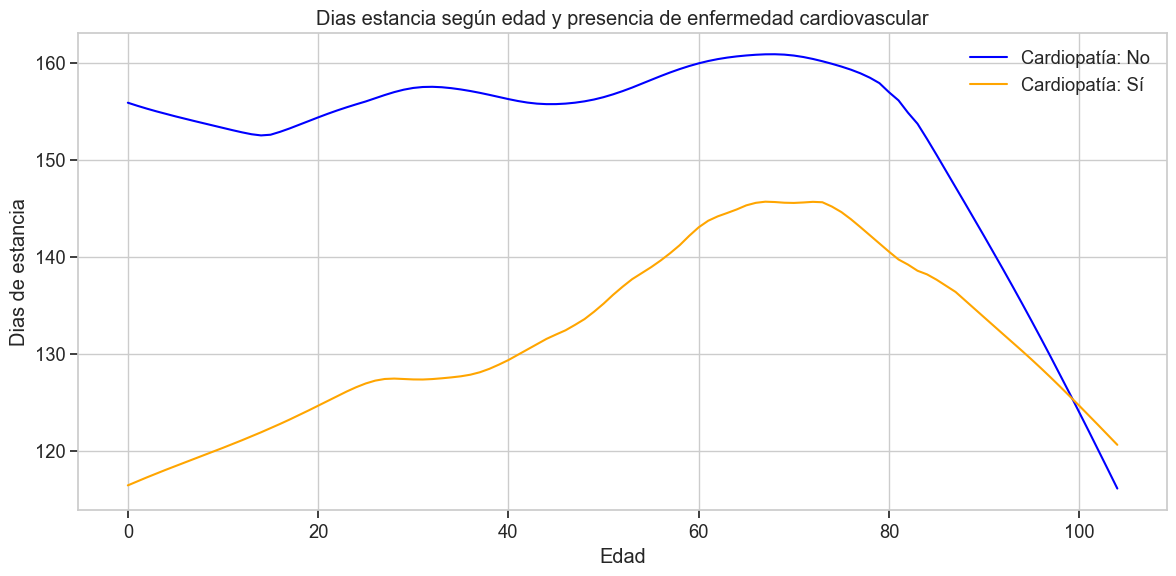

In [502]:
plt.figure(figsize=(12, 6))

Lowess_plot_cardiovascular(media_dias_estancia, 'EDAD', 'DIAS_ESTANCIA', frac=0.3)
plt.title('Dias estancia según edad y presencia de enfermedad cardiovascular')
plt.ylabel('Dias de estancia')
plt.xlabel('Edad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [503]:
# columnas_usar = [
#     'SEXO', 'PROVINCIA', 'NACIONALIDAD', 'PREVISION',
#     'TIPO_PROCEDENCIA', 'TIPO_INGRESO', 'TIPO_ACTIVIDAD',
#     'SERVICIOINGRESO', 'SERVICIOALTA', 'TIPOALTA',
#     'DIAS_ESTANCIA', 'EDAD', 'Multimorbilidad', 'Rango_Etario',
#     'Cardiovascular', 'IR_29301_PESO'
# ]

# df = df_ab_cardio[columnas_usar].copy()
# df = df.dropna()  # Si tienes pocos NaN; si no, puedes imputar

# columnas_categoricas = [
#     'SEXO', 'PROVINCIA', 'NACIONALIDAD', 'PREVISION',
#     'TIPO_PROCEDENCIA', 'TIPO_INGRESO', 'TIPO_ACTIVIDAD',
#     'SERVICIOINGRESO', 'SERVICIOALTA', 'TIPOALTA', 'Rango_Etario'
# ]

# df_match = pd.get_dummies(df, columns=columnas_categoricas, drop_first=True)

# X = df_match.drop(columns=['Cardiovascular', 'IR_29301_PESO'])
# y = df_match['Cardiovascular']



In [504]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import StandardScaler

# # Escalamos X para asegurar convergencia más rápida
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Modelo para estimar propensity scores
# model = LogisticRegression(max_iter=5000)  # aumentamos max_iter
# model.fit(X_scaled, y)
# propensity_scores = model.predict_proba(X_scaled)[:, 1]

# # Aseguramos que df_match tenga el mismo índice que X/y
# df_match = df_match.reset_index(drop=True)
# df_match['propensity_score'] = propensity_scores
# df_match['Cardiovascular'] = y.reset_index(drop=True)

# # Separar tratados y controles
# treated = df_match[df_match['Cardiovascular'] == 1].copy()
# control = df_match[df_match['Cardiovascular'] == 0].copy()

# # Matching usando nearest neighbor (1:1)
# nn = NearestNeighbors(n_neighbors=1)
# nn.fit(control[['propensity_score']])
# distances, indices = nn.kneighbors(treated[['propensity_score']])

# # Obtener controles emparejados por índice
# matched_control = control.iloc[indices.flatten()].copy()
# matched_treated = treated.reset_index(drop=True)

# # Añadir columnas para identificar pares
# matched_control['match_group'] = matched_treated.index
# matched_treated['match_group'] = matched_treated.index

# # Juntar los pares tratados y controles
# matched_df = pd.concat([matched_treated, matched_control], axis=0).sort_values(by="match_group").reset_index(drop=True)

# # matched_df ahora contiene pares tratados-controles emparejados por propensity score


In [505]:
# sns.boxplot(x='Cardiovascular', y='IR_29301_PESO', data=matched_df)
# plt.title("Peso GRD por presencia de enfermedad cardiovascular (Matching)")
# plt.show()

# # Test estadístico
# t_stat, p_val = ttest_ind(
#     matched_df[matched_df['Cardiovascular'] == 1]['IR_29301_PESO'],
#     matched_df[matched_df['Cardiovascular'] == 0]['IR_29301_PESO']
# )

# print(f"T-test: t = {t_stat:.2f}, p = {p_val:.4f}")

In [506]:

# treated = matched_df[matched_df['Cardiovascular'] == 1]['IR_29301_PESO']
# control = matched_df[matched_df['Cardiovascular'] == 0]['IR_29301_PESO']

# # Medias y desviaciones estándar
# mean_treated = np.mean(treated)
# mean_control = np.mean(control)
# std_treated = np.std(treated, ddof=1)
# std_control = np.std(control, ddof=1)

# # Desviación estándar combinada
# n1, n2 = len(treated), len(control)
# pooled_std = np.sqrt(((n1 - 1)*std_treated**2 + (n2 - 1)*std_control**2) / (n1 + n2 - 2))

# # Calcular Cohen's d
# cohen_d = (mean_treated - mean_control) / pooled_std

# print(f"Cohen's d: {cohen_d:.4f}")
